In [1]:
import pandas as pd
import pickle
import os
import json
import re
from PIL import Image

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [3]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan

BASE_DATA_PATH='../../data'
BASE_IMAGES_PATH='../../images'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
data_path = "../../data/computed/italy"

In [5]:
DATE = os.environ.get("REF_DATE")
if DATE is None:
    DATE = "2022-06-24"
print(DATE)

2022-07-15


In [6]:
pastdays='000'

## Data Loading

### Merging Regional Data from results 

In [7]:
REGIONS = [
    "Abruzzo", 
    "Basilicata", 
    "Calabria",  
    "Campania",  
    "Emilia-Romagna",
    "Friuli Venezia Giulia", 
    "Lazio",
    "Liguria",
    "Lombardia",
    "Marche",
    "Molise",
    "P.A. Bolzano",
    "P.A. Trento",
    "Piemonte",  
    "Puglia",
    "Sardegna",
    "Sicilia",
    "Toscana",
    "Umbria",
    "Valle d'Aosta",
    "Veneto"
]

In [8]:
SANITIZE_PATTERN = re.compile("[\.,'@;$&\"%?\- ]+")
regions = []
for r in REGIONS:
    print(r, " - ", SANITIZE_PATTERN.sub("_", r))
    regions.append(r)

Abruzzo  -  Abruzzo
Basilicata  -  Basilicata
Calabria  -  Calabria
Campania  -  Campania
Emilia-Romagna  -  Emilia_Romagna
Friuli Venezia Giulia  -  Friuli_Venezia_Giulia
Lazio  -  Lazio
Liguria  -  Liguria
Lombardia  -  Lombardia
Marche  -  Marche
Molise  -  Molise
P.A. Bolzano  -  P_A_Bolzano
P.A. Trento  -  P_A_Trento
Piemonte  -  Piemonte
Puglia  -  Puglia
Sardegna  -  Sardegna
Sicilia  -  Sicilia
Toscana  -  Toscana
Umbria  -  Umbria
Valle d'Aosta  -  Valle_d_Aosta
Veneto  -  Veneto


## load data from parquet

In [9]:
regional_calc_data = pd.read_parquet(os.path.join(BASE_DATA_PATH,
    f'computed/italy/{DATE}_TD_calc_Regions_all_MCMC_Rt.parquet'))

In [10]:
regional_calc_data.to_csv(
        os.path.join(
            BASE_DATA_PATH, 
            f'computed/italy/{DATE}_TD_calc_Regions_all_MCMC_Rt.csv'),
    index=False, quotechar='"',
    columns=[c for c in regional_calc_data.columns if "note" not in c]
)

### ISS Rt avg14

In [11]:
ISS_regions_Rt_avg14 = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_regions_avg14_from_ISS.csv'),
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [12]:
ISS_regions_Rt_avg14['Rt_95_err_max'] = (
    ISS_regions_Rt_avg14.Rt_range_14days_upper - ISS_regions_Rt_avg14.Rt_avg_14days
)
ISS_regions_Rt_avg14['Rt_95_err_min'] = (
    ISS_regions_Rt_avg14.Rt_avg_14days - ISS_regions_Rt_avg14.Rt_range_14days_lower
)

In [13]:
ISS_regions_Rt_avg14['Rt_reference_date'] = (
    (
        ISS_regions_Rt_avg14.computation_time_range_start + 
        (ISS_regions_Rt_avg14.computation_time_range_end - 
         ISS_regions_Rt_avg14.computation_time_range_start)/2
    ).dt.normalize()+timedelta(days=1, minutes=-1)
)
ISS_regions_Rt_avg14.sort_values(by='Rt_reference_date', inplace=True)
ISS_regions_Rt_avg14.reset_index(inplace=True, drop=True)

### ISS Rt punctual

In [14]:
ISS_regions_Rt_punctual = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_regions_punctual_from_ISS.csv'),
    parse_dates=['Date_reference']
)

## Regions Names Cleaning 

In [15]:
ISS_regions_Rt_avg14.Region.unique()

array(['Abruzzo', 'Veneto', "Valle d'Aosta", 'Umbria', 'Trento',
       'Toscana', 'Sardegna', 'Puglia', 'Piemonte', 'Molise', 'Sicilia',
       'Lombardia', 'Marche', 'Bolzano', 'Calabria', 'Campania',
       'Basilicata', 'Friuli V.G.', 'Lazio', 'Liguria', 'Emilia R.'],
      dtype=object)

In [16]:
regional_calc_data.Region.unique()

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)

In [17]:
mapper_ = {
    'Emilia R.': 'Emilia-Romagna', 
    'Friuli V.G.': "Friuli Venezia Giulia",
    'Bolzano': "P.A. Bolzano",
    'Trento': "P.A. Trento"
}

In [18]:
ISS_regions_Rt_avg14.Region = (
    ISS_regions_Rt_avg14
        .Region
        .apply(lambda x: mapper_[x] if x in mapper_ else x)
)

In [19]:
ISS_regions_Rt_punctual.Region.unique()

array(['Abruzzo', 'Basilicata', 'Bolzano', 'Calabria', 'Campania',
       'Emilia-Romagna', 'Friuli VG', 'Lazio', 'Liguria', 'Lombardia',
       'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia',
       'Toscana', 'Trento', 'Umbria', "Valle d'Aosta", 'Veneto'],
      dtype=object)

In [20]:
mapper_ = {
    'Friuli VG': "Friuli Venezia Giulia",
}

In [21]:
ISS_regions_Rt_punctual.Region = (
    ISS_regions_Rt_punctual
        .Region
        .apply(lambda x: mapper_[x] if x in mapper_ else x)
)

# Check Regions incidence above 20

When incidence is below 20, we skipt the computation for the $R_t$ index as it likely fails to converge.

The threshold has been empirically fitted on small regions.

In [22]:
def get_avg_by_region(df, days, cols=['nuovi_positivi','Rt_CI_extension']):
    aggr = df.loc[
        (df.data>df.data.max()-timedelta(days=days)),
        ['data','Region']+cols
    ].groupby(by='Region').agg(
        {'nuovi_positivi' : ['mean', 'sum'], 'Rt_CI_extension' : ['mean'] }
    )
    aggr.columns = aggr.columns.map('_'.join)
    return aggr.add_suffix(f'_{days}').reset_index()

def get_regions_Rt_CI(df, days=7):
    it_pop = pd.read_csv(os.path.join(BASE_DATA_PATH,'sources/italy_population_from_ISS.csv'))


    df['Rt_CI_extension'] = (
        df[f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}'] -
        df[f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}']
    )
    
    regions_avg = get_avg_by_region(df, days=days)
    regions_avg = pd.merge(left=regions_avg,right=it_pop,on='Region')
    
    regions_avg[f'incidenza_{days}'] = regions_avg[f'nuovi_positivi_sum_{days}'] / regions_avg.Popolazione*100000
    
    return regions_avg

In [23]:
regions_avg = get_regions_Rt_CI(regional_calc_data)

In [24]:
regions_avg.sort_values(by='incidenza_7')

,Region,nuovi_positivi_mean_7,nuovi_positivi_sum_7,Rt_CI_extension_mean_7,Popolazione,incidenza_7
13,Piemonte,5304.166667,31825,0.268276,4311217,738.190632
8,Lombardia,12629.500000,75777,0.540142,10027602,755.684161
17,Toscana,4804.333333,28826,0.224626,3692555,780.651879
12,P.A. Trento,776.833333,4661,0.307110,545425,854.562955
10,Molise,428.166667,2569,0.275729,300516,854.862969
11,P.A. Bolzano,777.500000,4665,0.219948,532644,875.819497
16,Sicilia,7158.333333,42950,0.141658,4875290,880.973234
7,Liguria,2269.333333,13616,0.133082,1524826,892.954344
19,Valle d'Aosta,161.285714,1129,0.477812,125034,902.954396
2,Calabria,2970.500000,17823,0.218978,1894110,940.969637


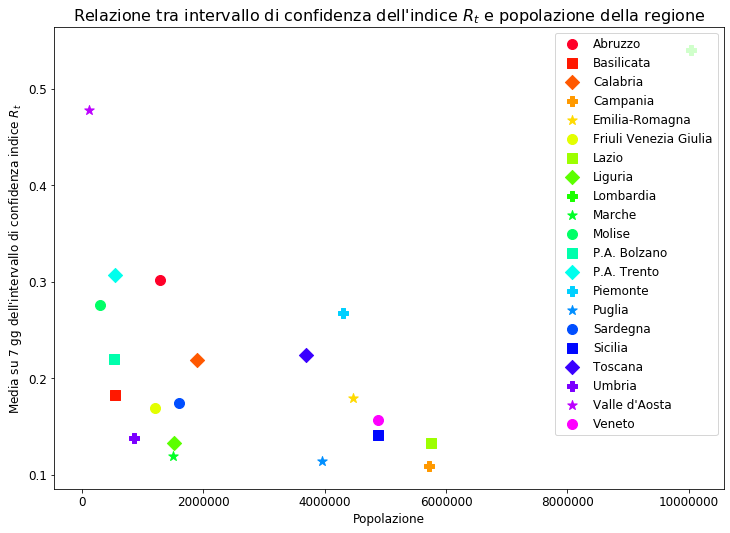

In [25]:
plotting.scatter(
    title='Relazione tra intervallo di confidenza dell\'indice $R_t$ e popolazione della regione',
    df=regions_avg,fieldx='Popolazione', fieldy='Rt_CI_extension_mean_7', fieldlabel='Region', 
    x_label='Popolazione',
    y_label='Media su 7 gg dell\'intervallo di confidenza indice $R_t$',
    time_on_x=False,
    figsize=(12,8.5),
    title_fontsize=16,
    tick_fontsize=12,
    legend_fontsize=12,
    label_fontsize=12,
    legend_loc='upper right',
)

In [26]:
report_region_avg = regions_avg.loc[(round(regions_avg.incidenza_7,0)<20)|(regions_avg.nuovi_positivi_mean_7<=5),['Region','nuovi_positivi_mean_7','incidenza_7']].copy()
report_region_avg.columns = pd.Index(['Regione', 'Media Nuovi Casi ultimi 7 giorni', 'Incidenza ultimi 7 giorni'], dtype='object')

In [27]:
html = report_region_avg.to_html(index=False, float_format=lambda f: f'{f:.0f}', justify='center')
with open(os.path.join(BASE_IMAGES_PATH,'italy/skip_regions.html'), 'w') as sr:
    sr.write(html)

In [28]:
blacklist = regions_avg.loc[(round(regions_avg.incidenza_7,0)<20)|(regions_avg.nuovi_positivi_mean_7<5)].Region.tolist()

In [29]:
blacklist = [] # ['Friuli Venezia Giulia', 'Molise', 'Sardegna']

# Rt Regions Single Plot

In [30]:
IMG_FILE_EXTENSION = os.path.join(BASE_IMAGES_PATH, 'italy/TD_Rt_{}_computation_MCMC_150dpi')

def plot_simulation_results(
    region, 
    simdf, 
    ISSdf, 
    ISSdfpunctual, 
    xmin=datetime(2020,7,25), 
    ylim=(0.2,2), 
    img_file_path_without_extension=IMG_FILE_EXTENSION, 
    subolot_ax=None, 
    legend_on=True, 
    legend_fontsize=20,
    disp_message=True):
    
    if img_file_path_without_extension:
        img_file_path_without_extension = \
            img_file_path_without_extension.format(region)
    
    region_df = simdf[simdf.Region==region]
    ISS_region_df = ISSdf[ISSdf.Region==region]
    ISS_region_punctual_df = ISSdfpunctual[ISSdfpunctual.Region==region]
    
    message_ = 'Aggiornamento del {}'.format(region_df.data.max().strftime('%d %b %Y'))
    message_ = message_ if disp_message else None
    
    plotting.plot_series(
        title=f'Rt giornaliero {region}',
        message=message_,
        data=[
            {
                'df': ISS_region_df,
                'xfield': 'Rt_reference_date',
                'yfields': ['Rt_avg_14days'],
                'bars': [['Rt_95_err_min','Rt_95_err_max']],
                'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
                'labels': [f'Stima di $R_t$ medio 14gg {region} pubblicata dall\'Istituto Superiore di Sanità, \ncon range di possibile variazione nel periodo'],
                'colors': ['blue']
            },
#             {
#                'df': ISS_region_punctual_df,
#                'xfield': 'Date_reference',
#                'yfields': ['Rt_avg_7days'],
#                'labels': [f'Stima di $R_t$ puntuale {region} pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
#                'colors': ['green']
#             },
            {
                'df': region_df,
                'xfield': 'data',
                'yfields': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
                ],
                'fill_between': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
                ],
                'labels': [
                    f'Stima di $R_t$ {region} sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
                ],
                'colors':['orange']
            },
        ],
        legend_fontsize=legend_fontsize,
        xlim=(xmin, datetime(*map(int,DATE.split("-")))),
        ylim=ylim,
        legend_on=legend_on,
        legend_loc='lower right',
        img_file_path_without_extension=img_file_path_without_extension,
        dpi=150,
        quality=60,
        ax_sub=subolot_ax
    )

In [31]:
def save_single_image(fig):
    # Avoid DecompressionBombError
    Image.MAX_IMAGE_PIXELS = 933120000

    IMG_FILE_EXTENSION_ALL = os.path.join(BASE_IMAGES_PATH, 'italy/TD_Rt_Regions_All_computation_MCMC_150dpi')
    png_path = '{}.png'.format(IMG_FILE_EXTENSION_ALL)
    jpg_path = '{}.jpg'.format(IMG_FILE_EXTENSION_ALL)
    fig.savefig(png_path, dpi=150)
    im = Image.open(png_path)
    rgb_im = im.convert('RGB')
    rgb_im.save(jpg_path, optimize=True, quality=40)

Abruzzo
Basilicata
Calabria
Campania
Emilia-Romagna
Friuli Venezia Giulia
Lazio
Liguria
Lombardia
Marche
Molise
P.A. Bolzano
P.A. Trento
Piemonte
Puglia
Sardegna
Sicilia
Toscana
Umbria
Valle d'Aosta
Veneto


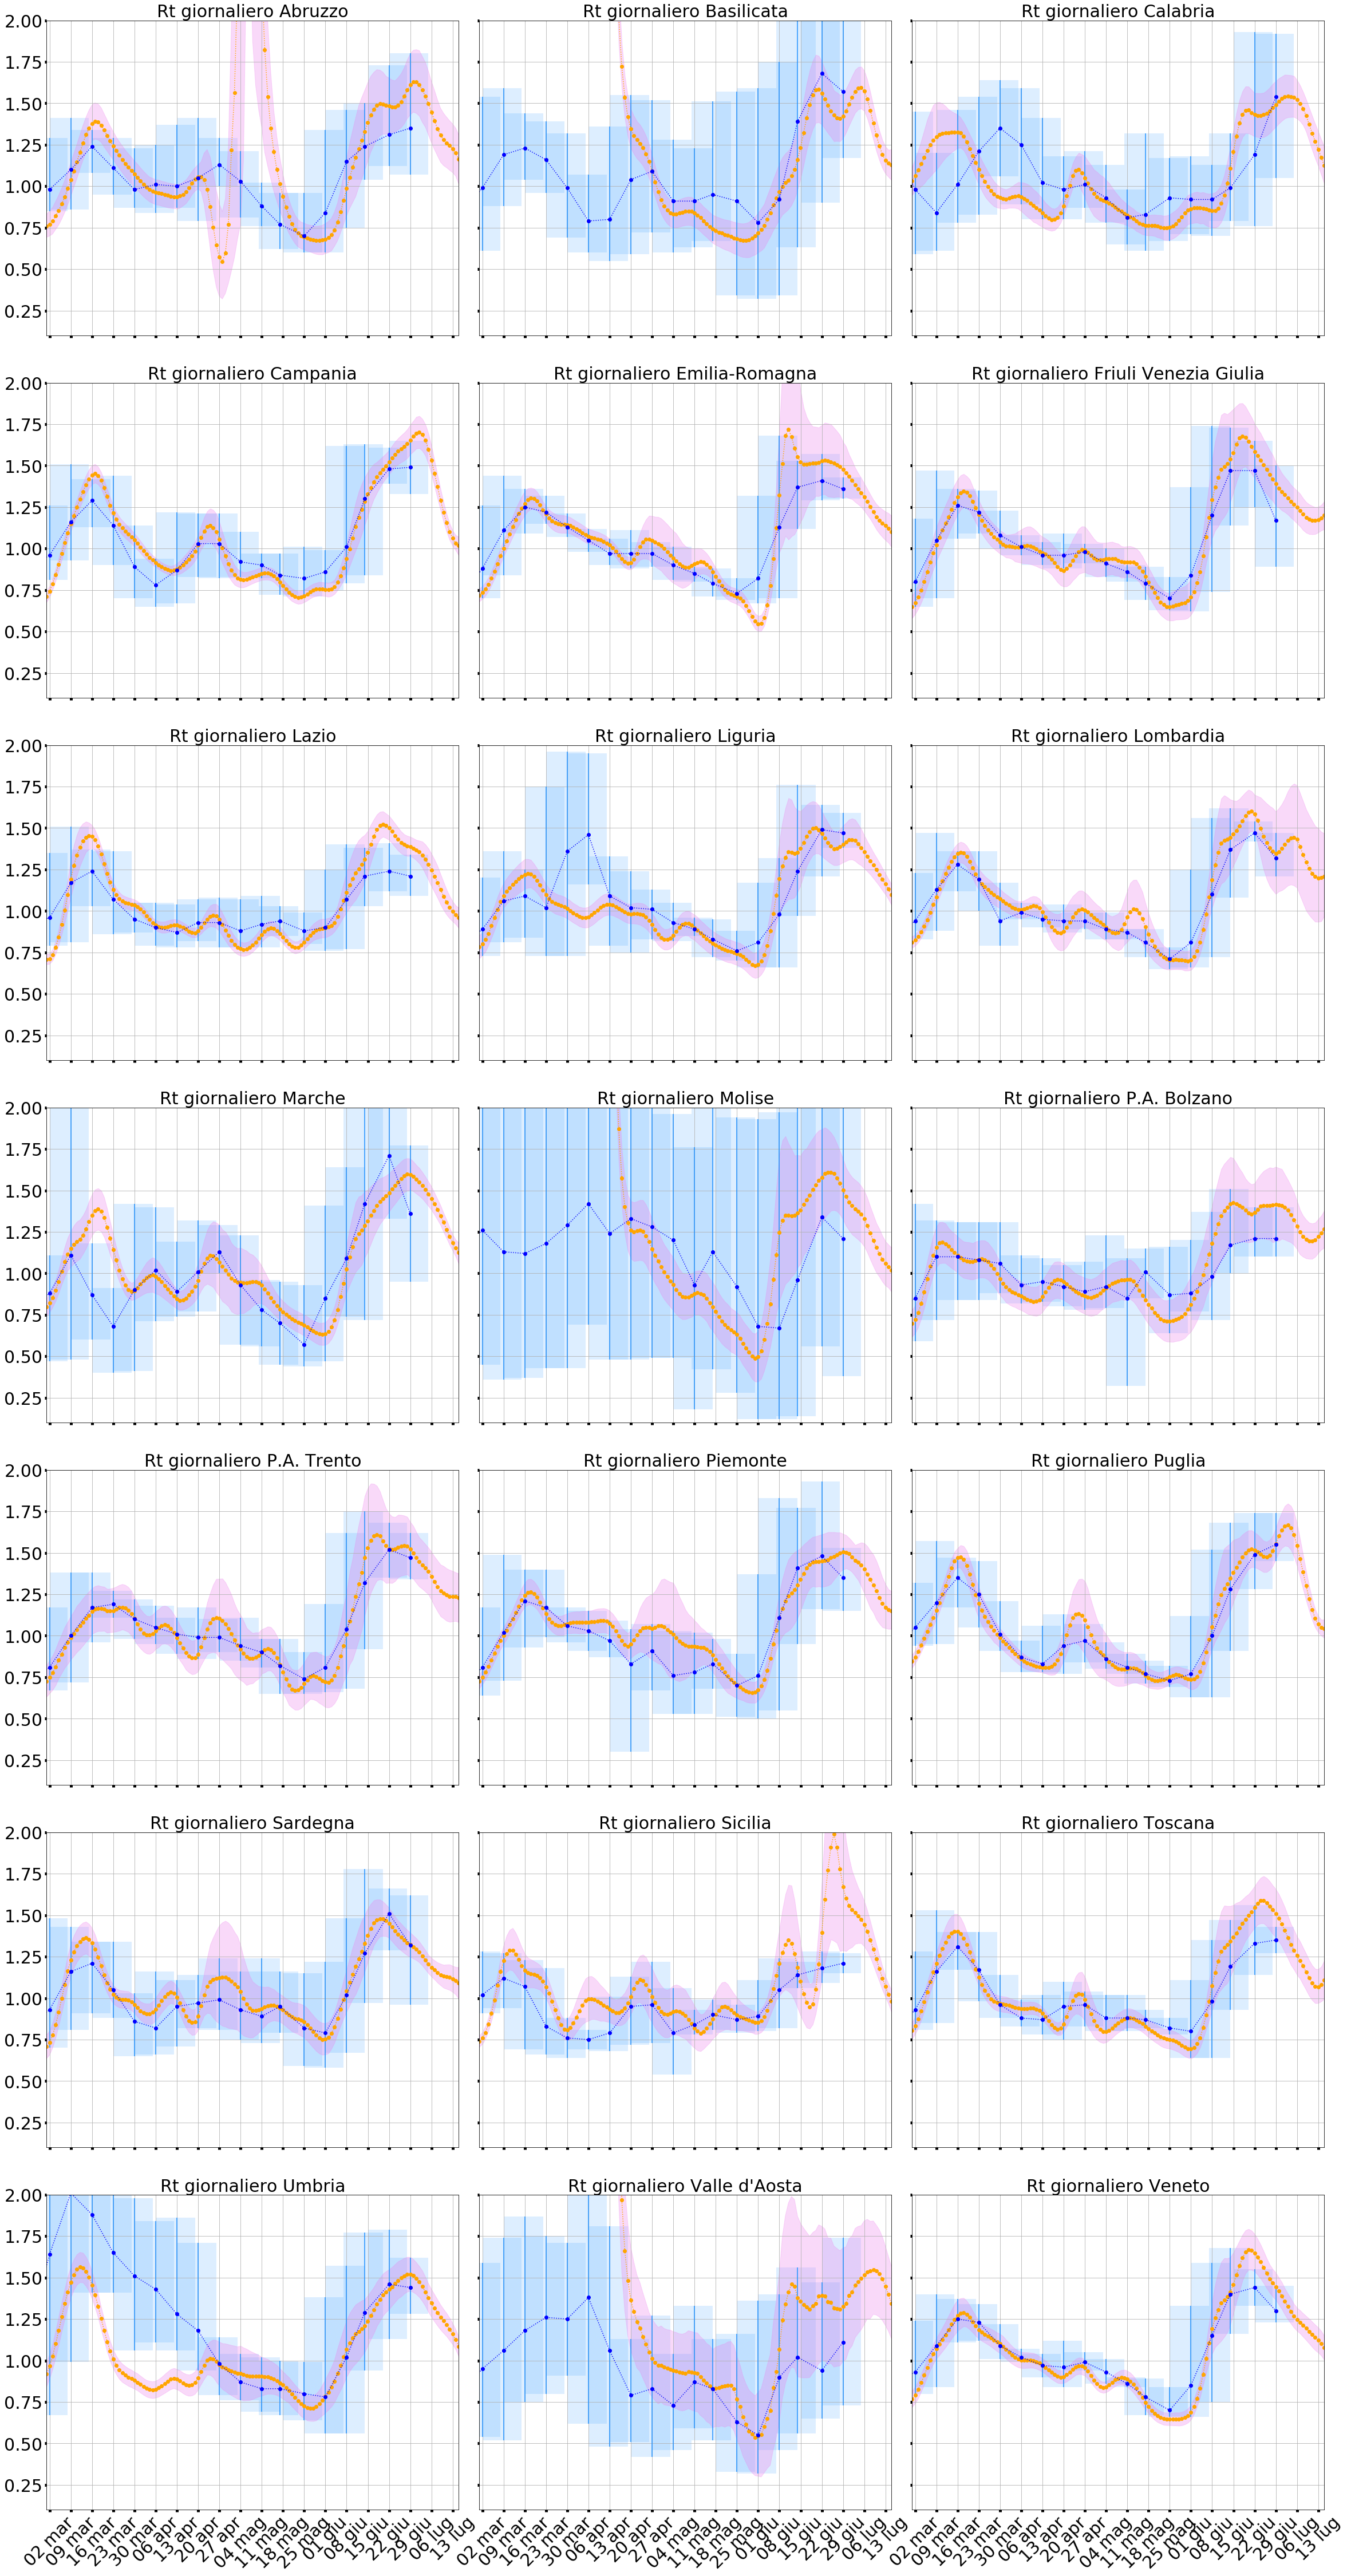

In [32]:
blacklist = [] #['Sicilia', 'Umbria', "Valle d'Aosta", "Veneto"] #'Molise', 'P.A. Bolzano', 'Valle d\'Aosta' #, 'Emilia-Romagna', 'Friuli Venezia Giulia', 'P.A. Trento']

fig, axs = plt.subplots(nrows=7, ncols=3, 
                        sharex=True, sharey=True, 
                        figsize=(40, 80), 
                        gridspec_kw={"wspace": 0.05, "hspace":0.15})

for region, ax in zip([r for r in regions if r not in blacklist], axs.flatten()[:len(regions)-len(blacklist)]):
    print(region)
    plot_simulation_results(
        region, 
        regional_calc_data, 
        ISS_regions_Rt_avg14, 
        ISS_regions_Rt_punctual, 
        xmin=datetime(2022,3,1), 
        ylim=(0.1,2.0),
        img_file_path_without_extension=None, 
        subolot_ax=ax,
        legend_on=False,
        disp_message=False
    )

save_single_image(fig)

# All Regions

In [33]:
#for region in regions:
#    plot_simulation_results(
#        region, 
#        regional_calc_data, 
#        ISS_regions_Rt_avg14, 
#        ISS_regions_Rt_punctual, 
#        xmin=datetime(2020,10,25), 
#        legend_fontsize=20)

In [34]:
datetime(*map(int,DATE.split("-")))

datetime.datetime(2022, 7, 15, 0, 0)

In [35]:
#blacklist = ["Abruzzo"]
blacklist = []
yy, mm, dd = DATE.split("-")
last_values = regional_calc_data.loc[
    (regional_calc_data.data==datetime(int(yy),int(mm),int(dd), 23, 59, 0))&(~regional_calc_data.Region.isin(blacklist)),
      ['data', 'Region',f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}',
       f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
       f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}']    
]
last_values['err_min'] = last_values[f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}'] - last_values[f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}']
last_values['err_max'] = last_values[f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}'] - last_values[f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}']

In [36]:
Rt_col = f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}'
Rt_max_col = f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}'
Rt_min_col = f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}'
for _, r in last_values.iterrows():
    print(f'{r.Region}: {r[Rt_col]:.2f} ({r[Rt_min_col]:.2f} - {r[Rt_max_col]:.2f})')


Abruzzo: 1.12 (0.95 - 1.28)
Basilicata: 1.13 (1.00 - 1.24)
Calabria: 1.08 (0.95 - 1.21)
Campania: 1.01 (0.93 - 1.08)
Emilia-Romagna: 1.08 (0.97 - 1.18)
Friuli Venezia Giulia: 1.22 (1.11 - 1.32)
Lazio: 0.95 (0.86 - 1.02)
Liguria: 1.07 (0.99 - 1.14)
Lombardia: 1.22 (0.98 - 1.45)
Marche: 1.10 (1.00 - 1.18)
Molise: 0.99 (0.84 - 1.14)
P.A. Bolzano: 1.29 (1.15 - 1.42)
P.A. Trento: 1.22 (1.06 - 1.38)
Piemonte: 1.15 (1.03 - 1.27)
Puglia: 1.05 (0.97 - 1.12)
Sardegna: 1.08 (0.96 - 1.19)
Sicilia: 0.95 (0.86 - 1.03)
Toscana: 1.15 (1.01 - 1.30)
Umbria: 1.04 (0.97 - 1.11)
Valle d'Aosta: 1.29 (1.06 - 1.52)
Veneto: 1.04 (0.97 - 1.12)


In [37]:
last_values

,data,Region,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000,err_min,err_max
18312,2022-07-15 23:59:00,Abruzzo,1.117475,0.953590,1.284874,0.163885,0.167399
18313,2022-07-15 23:59:00,Basilicata,1.129882,1.001550,1.235060,0.128332,0.105178
18314,2022-07-15 23:59:00,Calabria,1.079648,0.949890,1.205578,0.129758,0.125931
18315,2022-07-15 23:59:00,Campania,1.009098,0.927882,1.078679,0.081215,0.069582
18316,2022-07-15 23:59:00,Emilia-Romagna,1.080639,0.971349,1.182447,0.109290,0.101807
18317,2022-07-15 23:59:00,Friuli Venezia Giulia,1.221161,1.113493,1.321972,0.107668,0.100811
18318,2022-07-15 23:59:00,Lazio,0.948193,0.859053,1.018063,0.089140,0.069870
18319,2022-07-15 23:59:00,Liguria,1.067132,0.994118,1.141903,0.073014,0.074771
18320,2022-07-15 23:59:00,Lombardia,1.217048,0.981491,1.454324,0.235556,0.237276
18321,2022-07-15 23:59:00,Marche,1.103608,0.999648,1.178753,0.103959,0.075146


In [38]:
regional_calc_data[regional_calc_data.Region=="Umbria"]

,Region,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,...,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000,Rt_CI_extension
18,Umbria,2020-02-24 23:59:00,ITA,10,Umbria,43.106758,12.388247,0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
39,Umbria,2020-02-25 23:59:00,ITA,10,Umbria,43.106758,12.388247,0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
60,Umbria,2020-02-26 23:59:00,ITA,10,Umbria,43.106758,12.388247,0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
81,Umbria,2020-02-27 23:59:00,ITA,10,Umbria,43.106758,12.388247,0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
102,Umbria,2020-02-28 23:59:00,ITA,10,Umbria,43.106758,12.388247,0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18267,Umbria,2022-07-12 23:59:00,ITA,10,Umbria,43.106758,12.388247,266,8,274,...,145634.0,179157.0,1671540.0,2785811.0,ITI,ITI2,1.159790,1.096509,1.223925,0.127416
18288,Umbria,2022-07-13 23:59:00,ITA,10,Umbria,43.106758,12.388247,270,8,278,...,145841.0,181148.0,1672484.0,2791527.0,ITI,ITI2,1.125194,1.066436,1.186355,0.119919
18309,Umbria,2022-07-14 23:59:00,ITA,10,Umbria,43.106758,12.388247,269,11,280,...,146104.0,182891.0,1673211.0,2797069.0,ITI,ITI2,1.085423,1.024625,1.143645,0.119020
18330,Umbria,2022-07-15 23:59:00,ITA,10,Umbria,43.106758,12.388247,279,8,287,...,146344.0,184502.0,1673957.0,2802670.0,ITI,ITI2,1.040494,0.969447,1.110396,0.140948


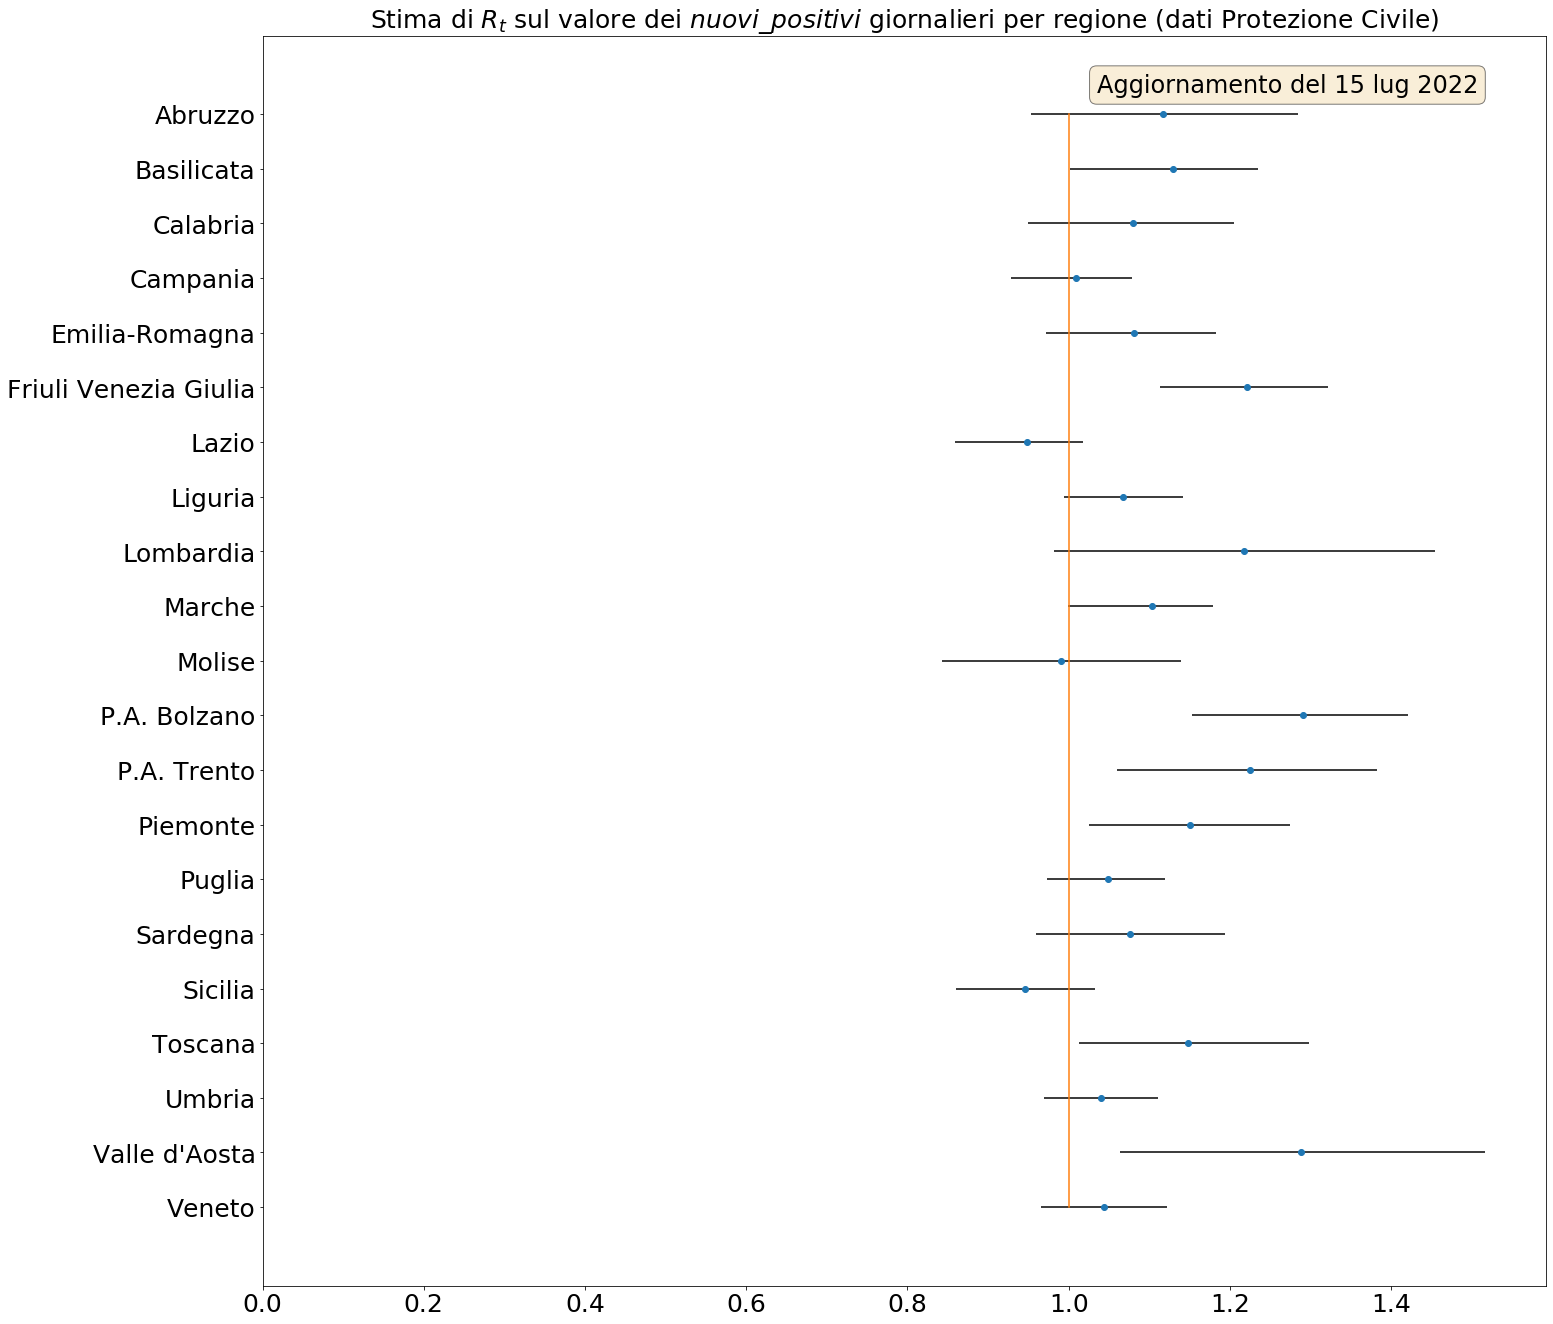

In [39]:
plotting.herrorbars(
    ylabels = last_values.Region.to_list(),
    xvalues = last_values[f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}'].to_numpy(),
    xerrors = last_values.loc[:,['err_min','err_max']].to_numpy().T,
    xrefvalue = 1.,
    figsize=(23,23),
    title=f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri per regione (dati Protezione Civile)',
    message='Aggiornamento del {}'.format(last_values.data.max().strftime('%d %b %Y')),
    title_fontsize=25,
    tick_fontsize=25,
    message_fontsize=20,    
    time_on_x=False,
    legend_on=False,
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/TD_Rt_Regions_bars'),
    dpi=150,
    quality=40
)